## KL Divergence: Gaussian

In this example we show how the KL divergence of the surrogate model improves as a function of iteration.

In [1]:
import alabi
from alabi.core import SurrogateModel
from alabi import benchmarks as bm
from alabi import metrics
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
from scipy.stats import multivariate_normal

We will check how the GP converges on a 4-dimensional Gaussian after 10, 20, 30... iterations

In [11]:
ncore = 4
ndim = 4
ntrain = 10 # number of initial training samples
nbatch = 5 # number of active learning iterations * 100
niter_per_batch = 10 # number of iterations per batch

# Define the multivariate normal likelihood function
mean = np.zeros(ndim)
cov = bm.random_gaussian_covariance(ndim)
lnlike = partial(multivariate_normal.logpdf, mean=mean, cov=cov)

print("mean:", mean)
print("cov:", cov)

mean: [0. 0. 0. 0.]
cov: [[ 0.44158713 -0.07856504  0.22354773 -0.40385537]
 [-0.07856504  0.50982271 -0.4032349   0.5080006 ]
 [ 0.22354773 -0.4032349   1.32856388 -0.85113813]
 [-0.40385537  0.5080006  -0.85113813  1.27353841]]


### Define `alabi` settings and run function

In [ ]:
gp_kwargs = {"kernel": "ExpSquaredKernel", 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50, "xatol": 1e-4, "fatol": 1e-3, "adaptive": True}}

al_kwargs={"algorithm": "bape", 
           "gp_opt_freq": 10, 
           "obj_opt_method": "nelder-mead", 
           "nopt": 1,
           "optimizer_kwargs": {"max_iter": 50, "xatol": 1e-3, "fatol": 1e-2, "adaptive": True}}

gp_opt_method = gp_kwargs["gp_opt_method"]
obj_opt_method = al_kwargs["obj_opt_method"]
save_base = f"convergence_results"


def run_alabi(ndim, with_mcmc=True):
    
    savedir = f"{save_base}/multivariate_normal_{ndim}d/"

    dynesty_sampler_kwargs = {"bound": "single",
                              "nlive": 50*ndim,
                              "sample": "auto"}
    
    dynesty_run_kwargs = {"wt_kwargs": {'pfrac': 1.0},
                          "stop_kwargs": {'pfrac': 1.0},
                          "maxiter": int(2e4),
                          "dlogz_init": 0.5}

    # Train surrogate model
    sm = SurrogateModel(lnlike_fn=lnlike,
                        bounds=[(-3., 3.) for _ in range(ndim)],
                        savedir=savedir,
                        cache=True,
                        verbose=True,
                        ncore=ncore)

    # Initialize surrogate model 
    sm.init_samples(ntrain=ntrain, reload=False, sampler="sobol")

    sm.init_gp(**gp_kwargs)

    if not with_mcmc:
        # Active training on surrogate model
        sm.active_train(niter=int(nbatch*niter_per_batch), **al_kwargs)

    else:
        for _ in range(nbatch):
            # Active training on surrogate model
            sm.active_train(niter=niter_per_batch, **al_kwargs)

            # Run MCMC on surrogate likelihood function
            sm.run_dynesty(like_fn=sm.surrogate_log_likelihood, 
                           sampler_kwargs=dynesty_sampler_kwargs,
                           run_kwargs=dynesty_run_kwargs)

    return sm

In [ ]:
sm = run_alabi(ndim, with_mcmc=True)

### Measure convergence using KL divergence metric

Compute the KL divergence between the surrogate model Gaussian ($P$) and the true Gaussian ($Q$) using the means and covariances:

$$ D_{\rm KL}(P \Vert Q) = 
     \frac{1}{2} \left[ \log \frac{\vert K_2 \vert}{\vert K_1 \vert} 
        + \mu^T K_2^{-1} \mu 
        + \mathrm{tr} \left(K_2^{-1} K_1\right) - k
    \right] $$
where $K_1$ is the covariance matrix of $P$, $K_2$ is the covariance matrix of $Q$, and $\mu = \mu_1 - \mu_2$ is the difference in the mean of $P$ and $Q$.

If $D_{\rm KL}(P \Vert Q) = 0$, then the two distributions are identical, whereas a larger KL divergence value indicates greater divergence.

In [17]:
batches = np.arange(ntrain, int(nbatch * niter_per_batch)+1, niter_per_batch)
metric = alabi.metrics.kl_divergence_gaussian
savedir = f"{save_base}/multivariate_normal_{ndim}d/"

kl_divergence = []
for it in batches:
    dynesty_samples_model = np.load(f"{savedir}dynesty_samples_final_surrogate_iter_{it}.npz")["samples"]

    kl_div = metrics.kl_divergence_gaussian(mean, cov, dynesty_samples_model.mean(axis=0), np.cov(dynesty_samples_model, rowvar=False))
    kl_divergence.append(kl_div)

Plot KL divergence vs. iteration. For this 4D Gaussian example it takes roughly ~30 active learning iterations for the surrogate model to converge.

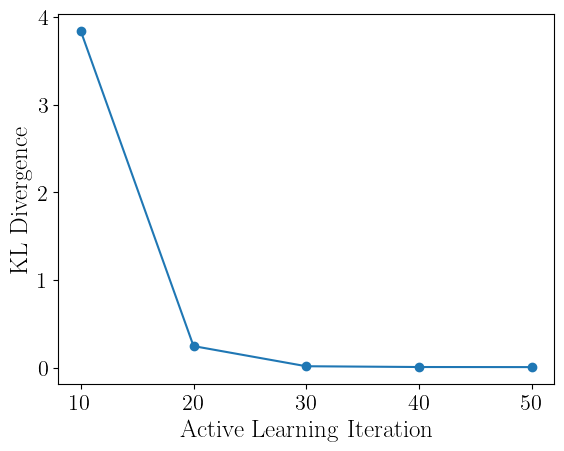

In [19]:
plt.plot(batches, kl_divergence, marker='o')
plt.xlabel("Active Learning Iteration", fontsize=18)
plt.ylabel("KL Divergence", fontsize=18)
plt.show()